# Index replication


## Overview 

In finance and invesment, index replication is a popular strategy to construct a portfolio of financial assets that replicates the performance of a specific market index such as S&P 500 or CAC40. The goal is to provide investors with returns that closely match those of the target index. There are two main methods of index replication: full replication and sampling.

* __Full replication__ involves buying all the stocks in the same proportion as they are found in the target index. This method ensures that the portfolio closely tracks the index, minimizing tracking errors, which are discrepancies between the fund's performance and the index's performance. Full replication is straightforward and transparent, but it can be costly and complex due to the need to frequently adjust the portfolio to match changes in the index's composition. 

* __Sampling__, or partial replication, involves selecting a representative sample of securities from the index rather than holding all of them. This method aims to mimic the index's performance while reducing trading costs and complexity. Sampling can lead to higher tracking errors compared to full replication, but it is often more cost-effective and practical.

## Optimization problem 

Formally speaking, portfolio construction is a process of of allocating a given capital among a set of assets. The expected return of a portfolio is calculated as the weighted sum of individual asset returns:
$$E(X) = \sum_{i=1}^{n} w_i E(X_i) $$

where 

* $E(X)$ is the expected return of the portfolio
* $w_i$ is the weight of asset i in the portfolio
* $E(X_i)$ is the expected return of asset i
* $n$ is the number of assets in the portfolio

One major challenge of porfolio managing is to capture and mitigate the flutuation of market. The variation of asset returns can be formulated by the variance of the corresponding return $X_i$. As a consequent, the variation of portfolio return, also called risk, is taken as 
$$ Var(X) =  Var (\sum_{i=1}^{n} w_i E(X_i)) = w \cdot \Sigma \cdot w^T$$

The minimization of tracking error may be expressed as a least-squares problem:

$$w^* = \underset{w \in P}{\mathrm{argmin}} \quad ||Xw - y||_2^2$$

where 

* $X \in \mathrm{R}^{T \times n} $ denotes the multivariate time series of asset returns 
* $y \in \mathrm{R}^T$ is the univariate index return series
* $||\cdot||_2^2$ the 2-norm. 

We tackle this minimization problem using quadratic programming 

$$ \min { \frac{1}{2}} x^T P x + q^T x$$ 

subject to constraints 

* $P = 2  ( ({\log({1 + X}})^T \cdot \log{(1 + X)})$
* $q = -2 ({\log{(1 + X)}})^T \cdot \log{(1 + y)}$

In [1]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import gurobipy as gp

sys.path.insert(1, '../src')
from backtest import Backtest, BacktestConstraintProvider
from data_loader import *
from optimization import *
from constraints import Constraints
from backtest_mutator import BacktestConfig, BacktestMutator
from universe_selection import DummySelection, LstmSelection
import quantstats as qs
qs.extend_pandas()

2024-08-19 00:09:50.373237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 00:09:50.405483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 00:09:50.416034: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 00:09:50.432518: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 00:09:51.878672: W tensorflow/compiler/tf2

## Loading data 

In [2]:
path = '../data/'  # Change this to your path

# Prepare data
raw_data = load_data_msci(path)
data = {'return_series': raw_data['X'],
        'return_series_index': raw_data['y']}

# Setup a mutator
start_date = '2023-02-01'
mutator = BacktestMutator(data, start_date='2023-01-01', quiet=True)

dates = data['return_series'].index.intersection(data['return_series_index'].index)
rebdates = dates[dates > start_date][::21].strftime('%Y-%m-%d').tolist()


## Optimization formulation

### Constraints 

We start by 

* setting optimization problem e.g. Least Square and choosing solver 
* defining objective function
* constructing the constraints 

In [3]:
# Setup a mutator
start_date = '2018-01-02'
mutator = BacktestMutator(data, start_date=start_date, quiet=True)

dates = data['return_series'].index.intersection(data['return_series_index'].index)
rebdates = dates[dates > start_date][::21].strftime('%Y-%m-%d').tolist()

In [4]:
bt_constraints = Constraints(selection=data['return_series'].columns)
bt_constraints.add_budget()
bt_constraints.add_box(box_type='LongOnly')

optimization = LeastSquares(solver_name='highs', sparse=True)
optimization.constraints = bt_constraints


In [5]:
bt = Backtest(rebdates, data, selection_model= DummySelection(model='dummy', data=data['return_series']), width=252)
bt.optimization = optimization

constraint_provider = BacktestConstraintProvider()
constraint_provider.add_budget()
bt.constraint_provider = constraint_provider
bt.run()

Rebalancing date: 2018-01-03
Rebalancing date: 2018-02-01
Rebalancing date: 2018-03-02
Rebalancing date: 2018-04-02
Rebalancing date: 2018-05-01


Rebalancing date: 2018-05-30
Rebalancing date: 2018-06-28
Rebalancing date: 2018-07-27
Rebalancing date: 2018-08-27
Rebalancing date: 2018-09-25
Rebalancing date: 2018-10-24
Rebalancing date: 2018-11-22
Rebalancing date: 2018-12-21
Rebalancing date: 2019-01-21
Rebalancing date: 2019-02-19
Rebalancing date: 2019-03-20
Rebalancing date: 2019-04-18
Rebalancing date: 2019-05-17
Rebalancing date: 2019-06-17
Rebalancing date: 2019-07-16
Rebalancing date: 2019-08-14
Rebalancing date: 2019-09-12
Rebalancing date: 2019-10-11
Rebalancing date: 2019-11-11
Rebalancing date: 2019-12-10
Rebalancing date: 2020-01-08
Rebalancing date: 2020-02-06
Rebalancing date: 2020-03-06
Rebalancing date: 2020-04-06
Rebalancing date: 2020-05-05
Rebalancing date: 2020-06-03
Rebalancing date: 2020-07-02
Rebalancing date: 2020-07-31
Rebalancing date: 2020-08-31
Rebalancing date: 2020-09-29
Rebalancing date: 2020-10-28
Rebalancing date: 2020-11-26
Rebalancing date: 2020-12-25
Rebalancing date: 2021-01-25
Rebalancing da

In [6]:
sim_bt = bt.strategy.simulate(return_series=bt.data['return_series'],
                              fc=0,
                              vc=0)

# Analyze weights
# bt.strategy.get_weights_df()

# print(bt.strategy.number_of_assets())
# bt.strategy.number_of_assets().plot()

{'Sharpe': 0.4490841574426831, 'VaR': -0.017462254454631065}

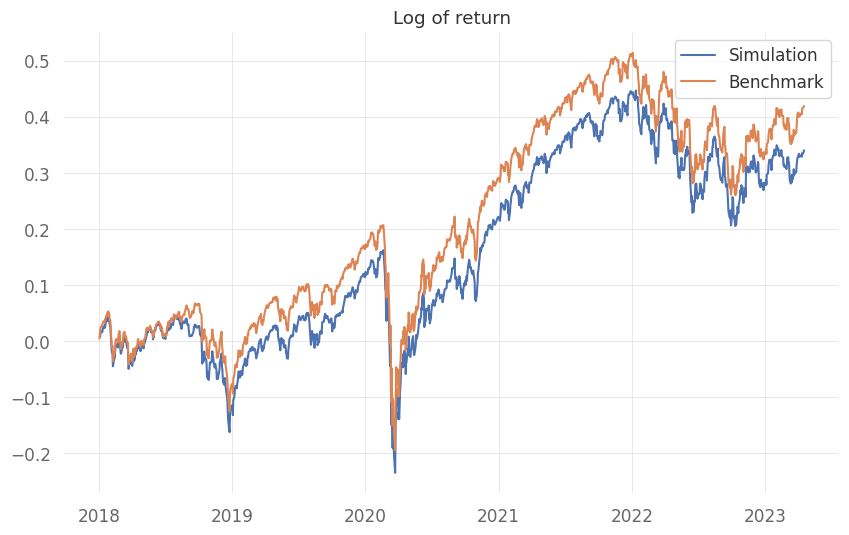

In [7]:
# Analyze simulation
# sim = pd.concat({'simulation': sim_bt,
#                  'index': bt.data['return_series_index']}, axis=1).dropna()
sim = np.log(1 + sim_bt ).cumsum()
benchmark = np.log(1 + bt.data['return_series_index'][start_date:]).cumsum()
plt.plot(sim, label="Simulation")
plt.plot(benchmark, label="Benchmark")
plt.title("Log of return")
plt.legend()
# Performance metrics
report = {'Sharpe': sim_bt.sharpe(),
          'VaR': sim_bt.value_at_risk()}
report


# Universe selection using lstm

In [8]:
lstm_selection = LstmSelection(model="LSTM", data=data['return_series'])
lstm_selection.load_model()

bt = Backtest(rebdates, data,
              selection_model= DummySelection(model='dummy', data=data['return_series']), width=252)
bt.optimization = optimization

I0000 00:00:1724018995.423428   12147 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724018995.494270   12147 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724018995.494683   12147 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724018995.496949   12147 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,274 (368.26 KB)

 Trainable params: 31,424 (122.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,850 (245.51 KB)

In [9]:
constraint_provider = BacktestConstraintProvider()
constraint_provider.add_budget()
bt.constraint_provider = constraint_provider
bt.run()

Rebalancing date: 2018-01-03
Rebalancing date: 2018-02-01
Rebalancing date: 2018-03-02
Rebalancing date: 2018-04-02
Rebalancing date: 2018-05-01
Rebalancing date: 2018-05-30
Rebalancing date: 2018-06-28
Rebalancing date: 2018-07-27
Rebalancing date: 2018-08-27
Rebalancing date: 2018-09-25
Rebalancing date: 2018-10-24
Rebalancing date: 2018-11-22
Rebalancing date: 2018-12-21
Rebalancing date: 2019-01-21
Rebalancing date: 2019-02-19
Rebalancing date: 2019-03-20
Rebalancing date: 2019-04-18
Rebalancing date: 2019-05-17
Rebalancing date: 2019-06-17
Rebalancing date: 2019-07-16
Rebalancing date: 2019-08-14
Rebalancing date: 2019-09-12
Rebalancing date: 2019-10-11
Rebalancing date: 2019-11-11
Rebalancing date: 2019-12-10
Rebalancing date: 2020-01-08
Rebalancing date: 2020-02-06
Rebalancing date: 2020-03-06
Rebalancing date: 2020-04-06
Rebalancing date: 2020-05-05
Rebalancing date: 2020-06-03
Rebalancing date: 2020-07-02
Rebalancing date: 2020-07-31
Rebalancing date: 2020-08-31
Rebalancing da

In [10]:
sim_bt = bt.strategy.simulate(return_series=bt.data['return_series'],
                              fc=0,
                              vc=0)

{'Sharpe': 0.5319444524614729, 'VaR': -0.017315474623356517}

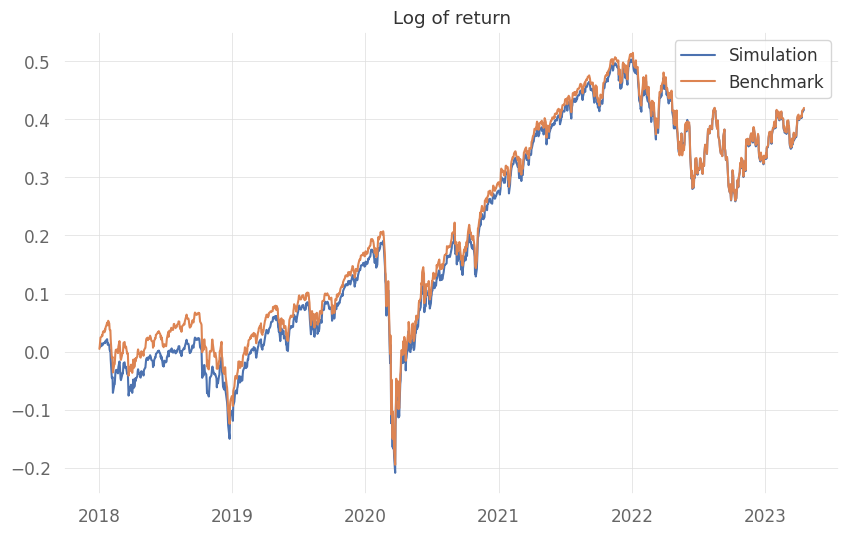

In [11]:
sim = np.log(1 + sim_bt ).cumsum()
benchmark = np.log(1 + bt.data['return_series_index'][start_date:]).cumsum()
plt.plot(sim, label="Simulation")
plt.plot(benchmark, label="Benchmark")
plt.title("Log of return")
plt.legend()
# Performance metrics
report = {'Sharpe': sim_bt.sharpe(),
          'VaR': sim_bt.value_at_risk()}
report